In [82]:
from catboost import CatBoostClassifier, Pool, FeaturesData, cv
import pandas as pd
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve

#from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap
%matplotlib inline

In [2]:
run utils.py

In [21]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

In [17]:
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [24]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)

In [59]:
from os import walk

def read_dataset(train=True, exclude=[]):
    
    dir_main = "../Features"
    dirname = '/Train/' if train else '/Test/'
    f = []
    for (dirpath, dirnames, filenames) in walk(dir_main + dirname):
        f.extend(filenames)
        break
        
    f.sort()
    
    f = [name for i, name in enumerate(f) if i not in exclude]
                 
    for i, name in tqdm(enumerate(f)):
        print(name)
        if i == 0: 
            left = pd.read_pickle(dir_main + dirname + name)
        else:
            right = pd.read_pickle(dir_main + dirname + name)
            if (right.ID.values != left.ID.values).sum() == 0:
                right.index = left.index
                left = pd.concat([left, right.drop('ID', axis=1)], axis=1)
            else:
                left = pd.merge(left, right, on='ID')
                                       
    return left


In [57]:
def check_files(train=True):
    dir_main = "../Features"
    dirname = '/Train/' if train else '/Test/'
    f = []
    for (dirpath, dirnames, filenames) in walk(dir_main + dirname):
        f.extend(filenames)
        break
        
    f.sort()
     
    for i, name in tqdm(enumerate(f)):
         print(name, pd.read_pickle(dir_main + dirname + name).shape[0])

In [58]:
check_files(train=False)

25_art_tfidf.pkl 71530
25_betrag_histogram.pkl 71530
25_betrag_stats.pkl 71530
25_doc2vec_2.pkl 71530
25_faktor_histogram.pkl 71530
25_faktor_stats.pkl 71530
25_glove_all.pkl 71530
25_leistung_tfidf.pkl 71530
25_nummer_kat_tfidf.pkl 71530
25_nummer_tfidf.pkl 71530
25_simple_features.pkl 71530
25_test.pkl 487980
25_typ_stats.pkl 71530
anzahl_histogram.pkl 76203
art_tfidf.pkl 76203
betrag_histogram.pkl 76203
betrag_stats.pkl 76203
doc2vec.pkl 76203
doc2vec_2.pkl 76203
faktor_histogram.pkl 76203
faktor_stats.pkl 76203
glove.pkl 76203
glove_all.pkl 76203
leistung_tfidf.pkl 76203
nummer_kat_tfidf.pkl 76203
nummer_tfidf.pkl 76203
simple_features.pkl 76203
typ_stats.pkl 76203



In [87]:
DATA = pd.read_pickle("../Data_original/All_Data.pkl")

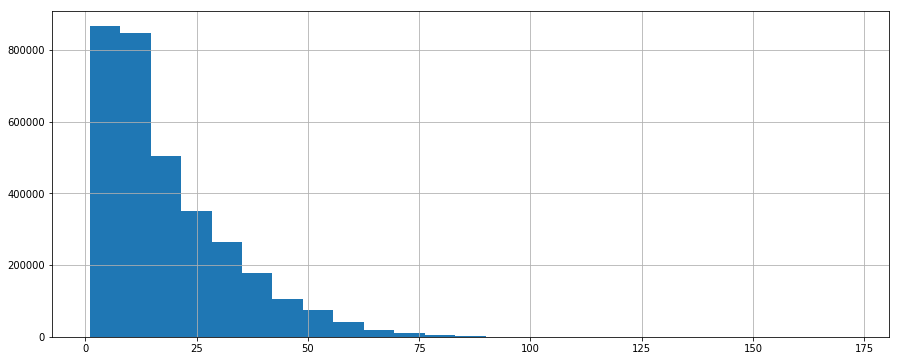

In [89]:
plt.figure(figsize=(15,6))
DATA.VISITS.hist(bins=25)

In [62]:
%%time
exclude = np.arange(12, 30)
train = read_dataset(train=True, exclude=exclude)
test = read_dataset(train=False, exclude=exclude)

25_art_tfidf.pkl
25_betrag_histogram.pkl
25_betrag_stats.pkl
25_doc2vec_2.pkl
25_faktor_histogram.pkl
25_faktor_stats.pkl
25_glove_all.pkl
25_leistung_tfidf.pkl
25_nummer_kat_tfidf.pkl
25_nummer_tfidf.pkl
25_simple_features.pkl
25_typ_stats.pkl


25_art_tfidf.pkl
25_betrag_histogram.pkl
25_betrag_stats.pkl
25_doc2vec_2.pkl
25_faktor_histogram.pkl
25_faktor_stats.pkl
25_glove_all.pkl
25_leistung_tfidf.pkl
25_nummer_kat_tfidf.pkl
25_nummer_tfidf.pkl
25_simple_features.pkl
25_typ_stats.pkl
CPU times: user 13.6 s, sys: 22.4 s, total: 36 s
Wall time: 35.9 s


In [63]:
%%time
targets = pd.read_pickle("../Data_original/Targets.pkl")

train = train.merge(targets[['ID', 'target']], on='ID', how='inner')
test = test.merge(targets[['ID', 'target']], on='ID', how='inner')

y_train = train.target.values
y_test = test.target.values

X_train = train.drop(['ID', 'target'], axis=1)
X_test = test.drop(['ID', 'target'], axis=1)

CPU times: user 4.72 s, sys: 6.76 s, total: 11.5 s
Wall time: 11.5 s


In [64]:
%%time
train_data = Pool(
    data  = X_train,
    label = y_train
)

test_data = Pool(
    data  = X_test,
    label = y_test
)

CPU times: user 3min 34s, sys: 2.81 s, total: 3min 37s
Wall time: 3min 37s


In [65]:
model = CatBoostClassifier(iterations=8000,  learning_rate=0.03, depth=5, loss_function='CrossEntropy', 
                           task_type = "GPU",
                           custom_loss=['AUC', 'Precision', 'Recall', 'F1'])

In [66]:
# Fit model 
model.fit(train_data, eval_set=(X_test, y_test), plot=True, verbose=False, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ROC AUC score: 0.9214
PR AUC score: 0.2658
CPU times: user 8.35 s, sys: 5.55 s, total: 13.9 s
Wall time: 5.68 s


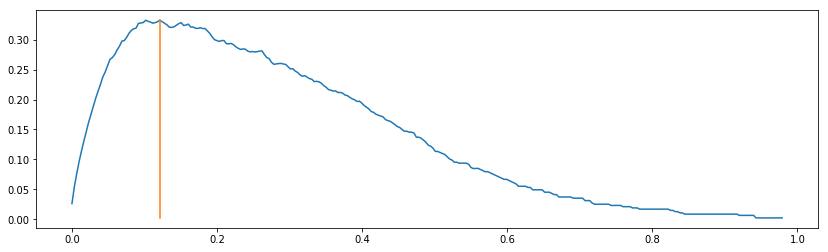

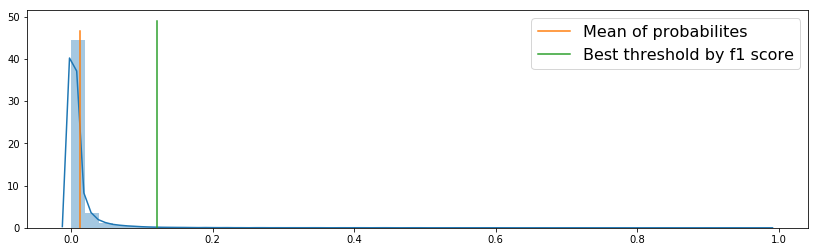

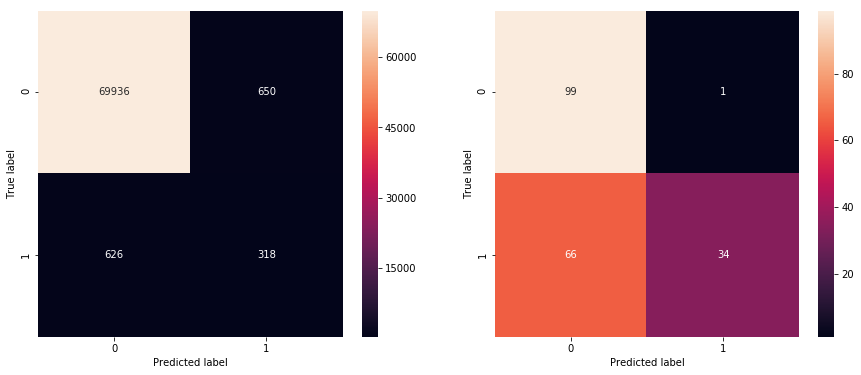

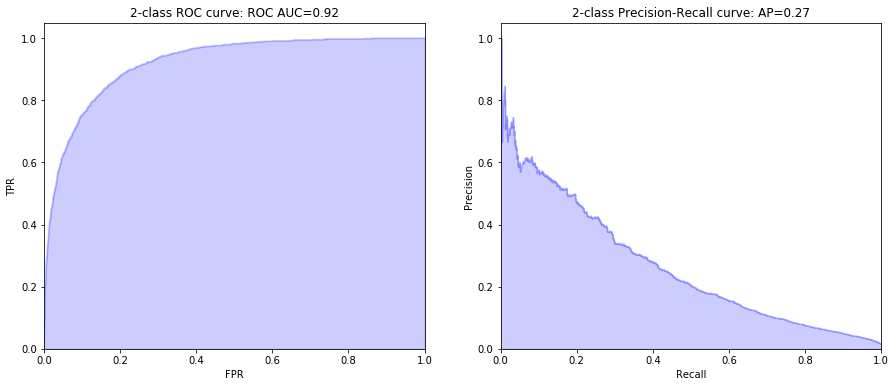

In [67]:
%%time 

prediction_proba = model.predict_proba(test_data)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1232: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ROC AUC score: 0.7561
PR AUC score: 0.0685
CPU times: user 3min 56s, sys: 10.4 s, total: 4min 6s
Wall time: 3min 56s


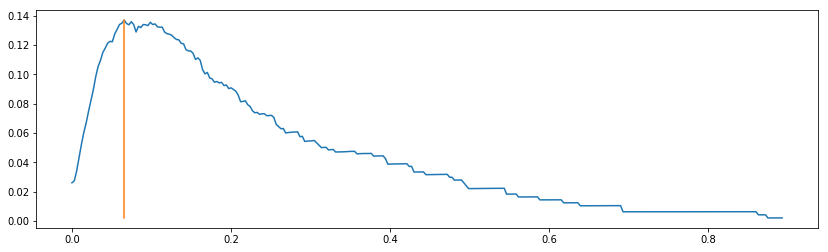

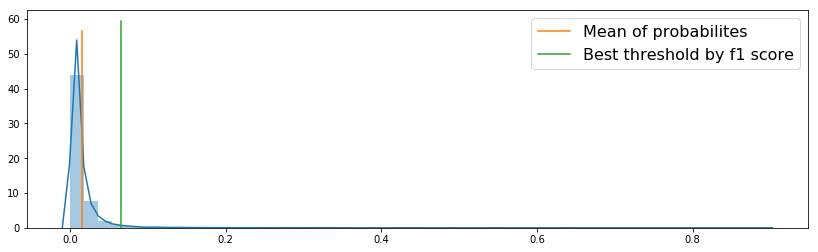

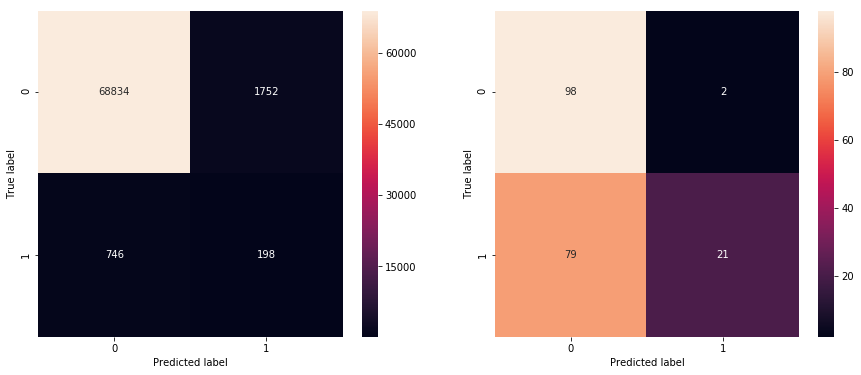

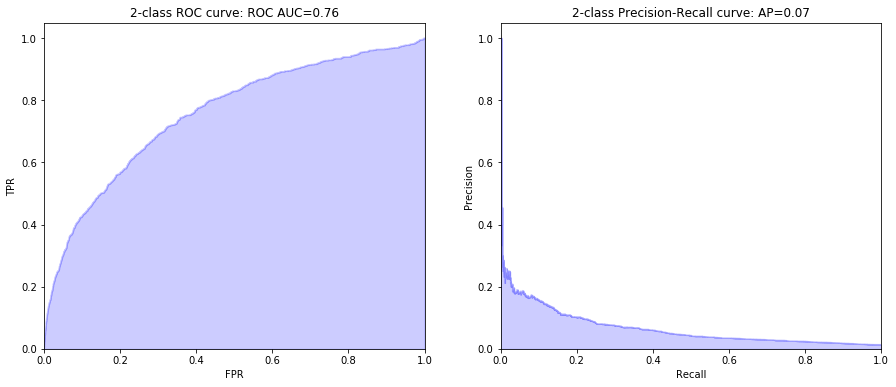

In [83]:
%%time 

model = LogisticRegression(n_jobs=-1)
model.fit(X_train, y_train)
prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [68]:
def construct_df(prediction, prediction_proba, y_test, ID, target, DATA):
    df = pd.DataFrame(np.array([prediction, prediction_proba[:,1], y_test]).T, columns=['pred', 'prob', 'real'])
    df = pd.concat([ID, df], axis=1)
    df = df.merge(target[['ID', 'KORREKTUR']], on='ID')
    
    ds = DATA[DATA.ID.isin(df.ID)]
    ds = pd.DataFrame(ds.ID.value_counts()).reset_index()
    ds.columns = ['ID', 'visits_num']
    df = df.merge(ds, on='ID')
    return df

def plot_stacked(d):
    
    #1
    er1 = d[d.pred==0][d.real==1].groupby(by='visits_num').sum().real.values
    er2 = d[d.pred==1][d.real==0].groupby(by='visits_num').sum().pred.values
    width = 0.45
    
    size = min(len(er1), len(er2))
    ind = np.arange(1, size + 1)
    
    plt.figure(figsize=(15,6))
    p1 = plt.bar(ind, er1[:size], width, color='#d62728')
    p2 = plt.bar(ind, er2[:size], width, bottom=er1[:size])
    
    plt.ylabel('Cases')
    plt.title('Number of 2 type of mistakes')
    plt.legend((p1[0], p2[0]), ('Real: Fraud', 'Real: non Fraud'))

    plt.show()
    
    #2
    er1 = d[d.pred==0][d.real==1].groupby(by='visits_num').KORREKTUR.sum().values
    er2 = d[d.pred==1][d.real==1].groupby(by='visits_num').KORREKTUR.sum().values
    width = 0.45
    
    size = min(len(er1), len(er2))
    ind = np.arange(1, size + 1)
    
    plt.figure(figsize=(15,6))
    p1 = plt.bar(ind, er2[:size], width, color='#d62728')
    p2 = plt.bar(ind, er1[:size], width, bottom=er2[:size])
    
    plt.ylabel('Volume')
    plt.title('Volume of fraud')
    plt.legend((p1[0], p2[0]), ('Detected', 'Not Detected'))

    plt.show()
    
    print('Volume of detected frauds: ', er2.sum())
    print('Volume of not detected frauds', er1.sum())
    
    #3
    plt.figure(figsize=(15,6))
    plt.title('Volume of Korrectur')
    plt.plot(er1.cumsum())
    

In [69]:
h = pd.DataFrame([X_train.columns, model.get_feature_importance()]).T
h.columns = ['col', 'val']
h.sort_values('val', ascending=False).head(10)

,col,val
2815,RECHNUNGSBETRAG,31.3592
1876,nummer_935,3.35854
368,BETRAG_max,2.49043
2457,nummer_1516,1.87042
715,NUMMER_embed_glove_all_14,1.06218
1074,nummer_133,0.927706
219,betrag_204,0.853954
366,BETRAG_std,0.812069
370,BETRAG_log_sum,0.733006
1756,nummer_815,0.724096


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


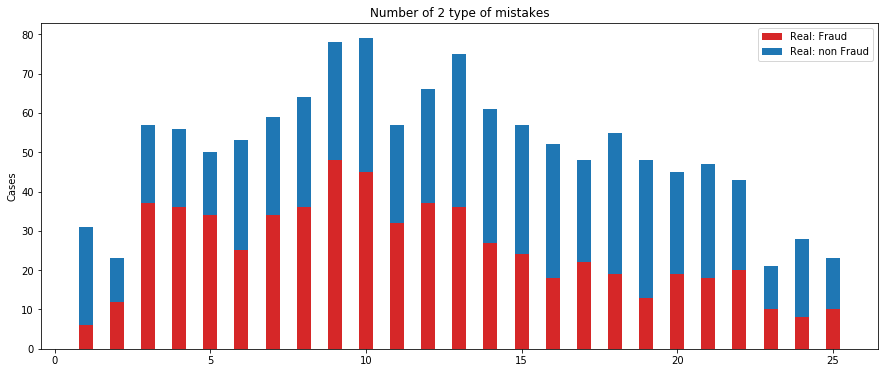

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


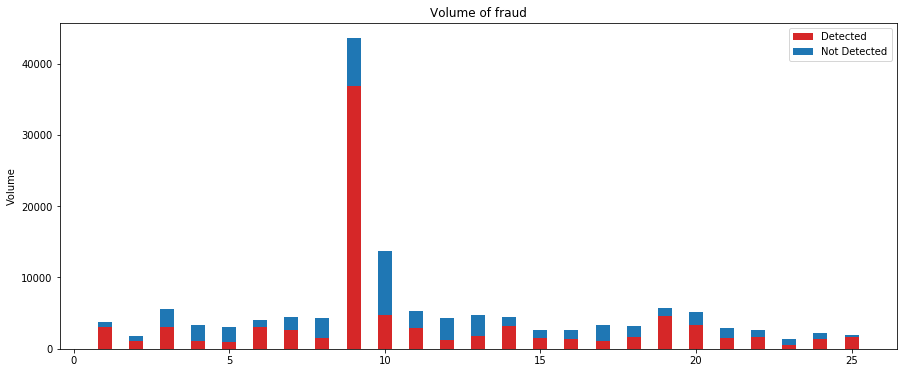

Volume of detected frauds:  87111.75
Volume of not detected frauds 53521.08


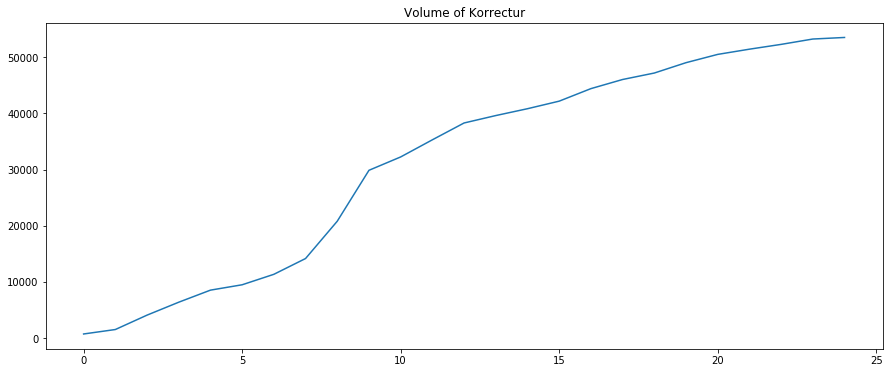

In [70]:
ds = pd.read_pickle("../Data_original/All_Data.pkl")
data_analysis = construct_df(prediction, prediction_proba, y_test, test.ID, targets, ds)
plot_stacked(data_analysis)

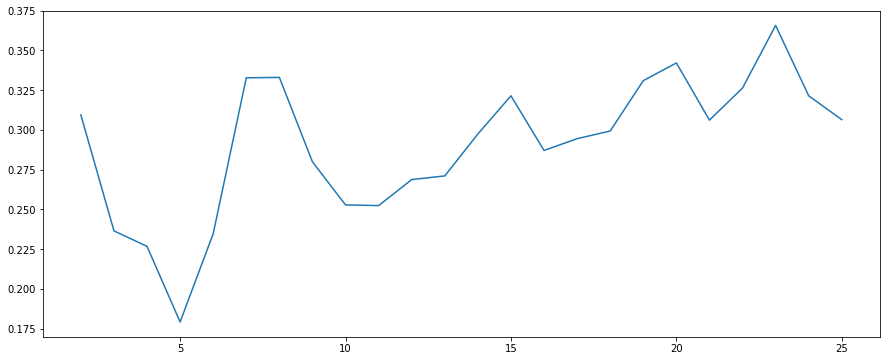

In [71]:
plot_pr_auc(data_analysis)

In [53]:
cor, neg = get_pos_neg_subsets(df, prediction, y_test)

In [116]:
# check it
def get_pos_neg_subsets(data, prediction, y_test):
    return data.iloc[(prediction == y_test).index],\
           data.iloc[(prediction != y_test).index]

def drop_duplicates(data, target=True):
    if target:
        return data.drop_duplicates(subset=['ID'])[['ID', 'RECHNUNGSBETRAG', 'ALTER', 'GESCHLECHT', 'VERSICHERUNG', 'target']].reset_index(drop=True)
    else:
        return data.drop_duplicates(subset=['ID'])[['ID', 'RECHNUNGSBETRAG', 'ALTER', 'GESCHLECHT', 'VERSICHERUNG', 'KORREKTUR']].reset_index(drop=True)

CPU times: user 28.6 s, sys: 14.3 s, total: 43 s
Wall time: 42.9 s


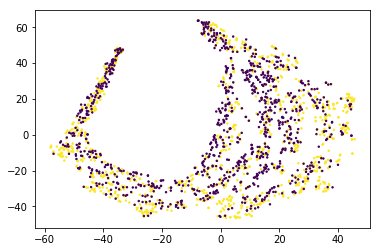

In [239]:
%%time
k=2000
X_trans = TSNE(n_components=2).fit_transform(test_df.drop(['ID', 'target'], axis=1).iloc[:k])
plt.scatter(*X_trans.T, c=test_df.target[:k], s=2)

CPU times: user 4.91 s, sys: 956 ms, total: 5.86 s
Wall time: 4.83 s


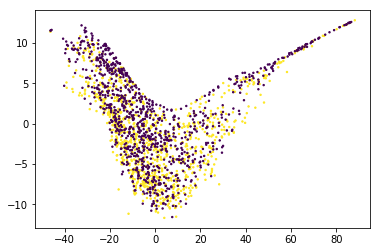

In [229]:
%%time
# n=1000
# test_df = pd.concat([df[df.target==1][:n], df[df.target==0][:n]], axis=0)
X_trans = Isomap(n_components=2, n_neighbors=10).fit_transform(test_df.drop(['ID', 'target'], axis=1))
plt.scatter(*X_trans.T, c=test_df.target, s=2)

In [ ]:
X_trans = Isomap(n_components=2, n_neighbors=750).fit_transform(neg.drop(['ID', 'target'], axis=1))
plt.scatter(*X_trans.T, c=neg.target, s=10)

## Cross Validation

In [3]:
df = pd.read_pickle('../Datasets/TransformedData_v3.pkl')

X = df.drop(['ID', 'target'], axis=1)
y = df.target

In [14]:
params = {}
params['loss_function'] = 'CrossEntropy'
params['iterations'] = 1000
params['custom_loss'] = 'AUC'
params['random_seed'] = 0
params['learning_rate'] = 0.05

cv_data = cv(
    params=params,
    pool=Pool(X, label=y),
    fold_count=4, 
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))